# Chapter 5: Tweaking the Trees: Bagging, Random Forests, and Boosting

* ***ensemble methods*** can be used to combine predictions of several base estimators in order to make a better predictions (more robust or more generalizable)

  * could be multiple types of algorithms



* some include combining trees in *bagging, boosting, RF*





## 5.1. Bias vs. Variance, Bagging and Boosting

  * **bagging/averaging/RF** methods reduce variance

      * trees may overlap but reduces effect of noise

  * **boosting** methods reduce bias

## Bagging: Generating New Trees by Resampling

* DT can be sensitive to sampling variation

  * eg. a few samples could change the entire tree structure

  * one thing we could do is generate more trees when the sample size is too small so as to reduce the variance

* Bagging method: using bootstrap method (from stats) on DTs

  * random sample **m** points from **n** data points (*with replacement*) to get **s** new samples

  * sample size **s**, and **m** are going to be are hyperparameters here

  * reduces variance; reduces overfitting

### 5.2.1. The Method

* aggregate **s** trees; combine predicted values to form final predicition 

  * eg. *average* values in regression 

  * *voting* or averaging votes among trees before choosing the max probability in classification 

   * `scikit-learn` implementation combines classifiers by averaging their probabilistic prediction (not voting)

* ***random forests*** is the specific version of the implememntation where we place a limit on the number of features considered in each split

  * reduces the correlation between trees reducing variance

    * since often the same features are chosen every time, otherwise

* ***ExtraTreesClassifier and ExtraTreesRegressor*** 

  * like RF but also with best of randomized split thresholds instead of best splits of all (adds even more randomness)

  * decreasing variance and increases bias even more




### 5.2.2. Example: Vertebrae Data

In [1]:
import pandas as pd
my_path = '/content/drive/My Drive/ecs171_yancey/Lecture_Notes/Chapter_2/column_3C.dat'
vert = pd.read_csv(my_path, sep=' ',header=None)

# note, that data is separated into groups of class (eg. all DH come first)
vert.head()

,0,1,2,3,4,5,6
0,63.03,22.55,39.61,40.48,98.67,-0.25,DH
1,39.06,10.06,25.02,29.00,114.41,4.56,DH
2,68.83,22.22,50.09,46.61,105.99,-3.53,DH
3,69.30,24.65,44.31,44.64,101.87,11.21,DH
4,49.71,9.65,28.32,40.06,108.17,7.92,DH


* `sklearn.ensemble` package has RF module

* we use test set sizes of 100 and default hyper-parameters

In [7]:
from sklearn import tree
from statistics import mean
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
nreps = 100
treeacc = list(range(0,100))
foracc = list(range(0,100))
etacc = list(range(0,100))

for i in range(0,nreps):
  
  X_train, X_test, y_train, y_test = train_test_split(vert.iloc[:,0:5], vert.iloc[:,6], test_size=100)

  clf = tree.DecisionTreeClassifier()
  clf = clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  treeacc[i] = accuracy_score(y_test, y_pred)

  clf = RandomForestClassifier()
  clf = clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  foracc[i] = accuracy_score(y_test, y_pred)

  clf = ExtraTreesClassifier()
  clf = clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  etacc[i] = accuracy_score(y_test, y_pred)

print('The DT accuracy is:', mean(treeacc))
print('The RF accuracy is:', mean(foracc))
print('The ET accuracy is:', mean(etacc))

The DT accuracy is: 0.6441
The RF accuracy is: 0.7174
The ET accuracy is: 0.7094


* So we have an improvement using RF

### 5.2.3. Parallelization

* parallel construction of the trees and predictions through the n_jobs parameter.

* **n_jobs=k** then computations are partitioned into **k** jobs (run on k cores)

  * **n_jobs=-1** then all cores available on the machine are used.
  
  * Due to the inter-process communication overhead this is mostly only helpful if building a large number of trees, or on large datasets (eg. large trees).

#### 5.2.3.1. Ex. Remote-Sensing Soil Analysis

From the website:

> Advances in rapid, low cost analysis of soil samples using infrared spectroscopy, georeferencing of soil samples, and greater availability of earth remote sensing data provide new opportunities for predicting soil functional properties at unsampled locations. Soil functional properties are those properties related to a soil’s capacity to support essential ecosystem services such as primary productivity, nutrient and water retention, and resistance to soil erosion. Digital mapping of soil functional properties, especially in data sparse regions such as Africa, is important for planning sustainable agricultural intensification and natural resources management.



In [1]:
import pandas as pd
my_path = '/content/drive/My Drive/ecs171_yancey/Lecture_Notes/Chapter_5/training.csv'
afrsoil = pd.read_csv(my_path)

afrsoil.head()

,PIDN,m7497.96,m7496.04,m7494.11,m7492.18,m7490.25,m7488.32,m7486.39,m7484.46,m7482.54,m7480.61,m7478.68,m7476.75,m7474.82,m7472.89,m7470.97,m7469.04,m7467.11,m7465.18,m7463.25,m7461.32,m7459.39,m7457.47,m7455.54,m7453.61,m7451.68,m7449.75,m7447.82,m7445.89,m7443.97,m7442.04,m7440.11,m7438.18,m7436.25,m7434.32,m7432.4,m7430.47,m7428.54,m7426.61,m7424.68,...,m634.473,m632.544,m630.616,m628.687,m626.759,m624.83,m622.902,m620.973,m619.045,m617.116,m615.188,m613.259,m611.331,m609.402,m607.474,m605.545,m603.617,m601.688,m599.76,BSAN,BSAS,BSAV,CTI,ELEV,EVI,LSTD,LSTN,REF1,REF2,REF3,REF7,RELI,TMAP,TMFI,Depth,Ca,P,pH,SOC,Sand
0,XNhoFZW5,0.302553,0.301137,0.299748,0.300354,0.302679,0.303799,0.301702,0.298936,0.298126,0.298120,0.298163,0.299124,0.300828,0.302522,0.303633,0.303364,0.302018,0.301226,0.300803,0.299270,0.297354,0.296703,0.297569,0.298991,0.299680,0.299230,0.298567,0.298865,0.299278,0.298186,0.296781,0.296565,0.296190,0.294805,0.293779,0.293980,0.295162,0.297448,0.300198,...,1.91489,1.91967,1.91974,1.91909,1.92077,1.91855,1.90573,1.88994,1.87770,1.86431,1.84816,1.83288,1.81858,1.80247,1.78462,1.76644,1.75086,1.74335,1.74246,-0.630435,-0.700000,-0.783875,-0.364146,1.165479,1.062682,-0.716713,-0.090016,-0.861091,-0.537106,-0.722567,-0.646673,1.687734,0.190708,0.056843,Topsoil,-0.295749,-0.041336,-1.129366,0.353258,1.269748
1,9XNspFTd,0.270192,0.268555,0.266964,0.267938,0.271013,0.272346,0.269870,0.266976,0.266544,0.266766,0.266464,0.266817,0.268150,0.269933,0.271409,0.271396,0.270126,0.269351,0.268984,0.267680,0.265901,0.265088,0.265679,0.266744,0.267202,0.266808,0.266266,0.266768,0.267507,0.266740,0.265624,0.265355,0.264461,0.262806,0.262251,0.263087,0.264431,0.266533,0.269126,...,2.00603,2.00192,2.00225,2.00244,1.99688,1.98540,1.96969,1.94942,1.92816,1.91071,1.89728,1.88298,1.86131,1.83355,1.80581,1.78410,1.77195,1.76479,1.75437,-0.630435,-0.700000,-0.783875,-0.364146,1.165479,1.062682,-0.716713,-0.090016,-0.861091,-0.537106,-0.722567,-0.646673,1.687734,0.190708,0.056843,Subsoil,-0.387442,-0.231552,-1.531538,-0.264023,1.692209
2,WDId41qG,0.317433,0.316265,0.314948,0.315224,0.316942,0.317764,0.316067,0.313874,0.313301,0.313296,0.313051,0.313306,0.314301,0.315640,0.316764,0.316759,0.315631,0.314860,0.314275,0.312711,0.311094,0.310565,0.311120,0.312103,0.312638,0.312326,0.311623,0.311752,0.312137,0.311122,0.309909,0.309824,0.309471,0.308209,0.307262,0.307201,0.307804,0.309592,0.312165,...,1.79495,1.79606,1.79749,1.79798,1.79977,1.80183,1.80012,1.79366,1.78411,1.77356,1.76544,1.76124,1.75742,1.75113,1.74128,1.72894,1.71991,1.71562,1.71158,-0.753623,-0.836364,-0.929451,-0.633972,1.544098,1.156705,-1.282552,-0.088336,-0.935273,-0.631725,-0.832298,-0.814516,1.806660,0.190708,0.056843,Topsoil,-0.248601,-0.224635,-0.259551,0.064152,2.091835
3,JrrJf1mN,0.261116,0.259767,0.258384,0.259001,0.261310,0.262417,0.260534,0.258039,0.257246,0.257124,0.257018,0.257568,0.258724,0.260107,0.261175,0.261028,0.259906,0.259251,0.258669,0.257007,0.255397,0.255119,0.256042,0.257195,0.257301,0.256440,0.256007,0.256729,0.257216,0.256001,0.254599,0.254345,0.253791,0.252452,0.251695,0.252027,0.253043,0.254901,0.257175,...,1.75317,1.76090,1.76944,1.77287,1.77080,1.76396,1.75453,1.74775,1.74264,1.73527,1.72770,1.72349,1.72149,1.71630,1.70737,1.69952,1.69356,1.68812,1.68178,-0.753623,-0.836364,-0.929451,-0.633972,1.544098,1.156705,-1.282552,-0.088336,-0.935273,-0.631725,-0.832298,-0.814516,1.806660,0.190708,0.056843,Subsoil,-0.332195,-0.318014,-0.577548,-0.318719,2.118477
4,ZoIitegA,0.260038,0.258425,0.256544,0.257030,0.259602,0.260786,0.258717,0.256352,0.255902,0.255822,0.255720,0.256521,0.257968,0.259571,0.260714,0.260465,0.259352,0.258872,0.258484,0.257105,0.255502,0.254720,0.255194,0.256394,0.257036,0.256583,0.255867,0.256101,0.256414,0.255297,0.254055,0.253889,0.253455,0.252198,0.251296,0.251400,0.252441,0.254763,0.257593,...,1.74973,1.75710,1.76209,1.76110,1.75564,1.75006,1.74568,1.74050,1.73201,1.72088,1.70944,1.69711,1.68257,1.66762,1.65639,1.64929,1.6

In [0]:
def findOverallLoss(ypreds,Y):
  err = (ypreds.reset_index(drop=True).T - Y.reset_index(drop=True).values.squeeze()) ** 2
  MAPE = err.mean(axis=1)
  return MAPE

* n_jobs=-1 means all available cores are used in compuation

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import time


X_train, X_test, y_train, y_test = train_test_split(afrsoil.iloc[:,list(range(1,3594)) + [3497]], pd.DataFrame(afrsoil.loc[:,'pH']), test_size=250)
y_train

start_time = time.time()
clf = RandomForestRegressor()
clf = clf.fit(X_train, y_train.values.ravel())
y_pred = clf.predict(X_test)
print('Loss:', findOverallLoss(y_test, pd.DataFrame(y_pred)))

print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
clf = RandomForestRegressor(n_jobs=-1)
clf = clf.fit(X_train, y_train.values.ravel())
y_pred = clf.predict(X_test)
print('Parallel loss:', findOverallLoss(y_test, pd.DataFrame(y_pred)))

print("--- %s seconds in parallel ---" % (time.time() - start_time))


Loss: pH    0.225813
dtype: float64
--- 166.37320971488953 seconds ---
Parallel loss: pH    0.229848
dtype: float64
--- 128.6044135093689 seconds in parallel ---


* That wasnt much faster, but lets try a max on the number of features considered for each tree...

In [4]:
start_time = time.time()
clf = RandomForestRegressor(n_jobs=-1, max_features=1000)
clf = clf.fit(X_train, y_train.values.ravel())
y_pred = clf.predict(X_test)
print('Parallel accuracy (with max val on features):', findOverallLoss(y_test, pd.DataFrame(y_pred)))

print("--- %s seconds in parallel (with max val on features) ---" % (time.time() - start_time))

Parallel accuracy (with max val on features): pH    0.182046
dtype: float64
--- 38.39659237861633 seconds in parallel (with max val on features) ---


That is way faster (less than 25% of the time) with slightly better accuracy!

* this is because reducing features decreases variance and saves time spent comparing features

* lets compare this to guessing the mean pH

* way better!

In [31]:
from sklearn.metrics import mean_squared_error
#y_pred = pd.DataFrame(y_pred.loc[:,'pH'])
m=abs(afrsoil.loc[:,'pH'].mean())
abs(y_test.subtract(m)).mean()


pH    0.658468
dtype: float64

## 5.3. Boosting: Repeatedly Tweaking a Tree

* eg. imagine if we had 12.5 as threshold value but more would be predicted correct if it was slightly modified to 11.9 - this is the idea of boosting

  * tweak tree to form new tree ***s*** times

### 5.3.1. Adaboost Implementation

* in the ***adaptive boosting*** method, we *tweak* the trees (by a ***weight*** equal to the amount of the prediction error in the previous iteration) so that the next tree will adapt to the threshold on each split 

  * the prediction accuracy with each new tree increases because the higher weighted values have more weight in the calculation of whether or not to make a split thus reducing overall error

  * we form new trees based on the old ones until we have ***s*** trees (where ***s*** is a hyperparameter)

* the sub-trees within ***s*** are called ***weak learners*** because the final prediction made by the boosting classifier is their weighted sum



**sklearn**

  * the number of weak learners (***s***) is set in `n_estimators` 
  
  * we may also often want change to change the `max_depth`, `min_samples_split`, and `base_estimator` paremeters to improve accuracy

    * the default base estimators are *'stumps'* (one-level DT's)



**algoithm:**

* we start with a weight **1/n** for each sample of our **n** data points 

* in each iteration (up to ***s*** iterations) weights are updated for each tree (according to the error in the previous one)

  * the decision trees will grow in favor splitting sets of samples with high weights


In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

X, y = load_iris(return_X_y=True)
clf = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

0.9466666666666665

### 5.3.2. Gradient Boosting (AKA Gradient Boosted Decision Trees (GBDT))

* we fit the data to the ***residuals*** (difference between predicted an actual value)

**algorithm**

  * 1. start with 1 tree (CurrentTree)

  * 2. calculate residual for each data point

  * 3. fit new tree T to residuals (eg. as the data) set new tree to CurrentTree=T 

    * so we are pretty much working on the "leftover" that we couldnt predict  in the last iteration

* Then we form our prediction as the sum of all the trees

  * 4. go to step 2

* it is called gradient since we are minimizing the partial derivatives of loss function 



![alt text](https://miro.medium.com/max/1400/1*fHenn7NVqcWvw25D3-zRiQ.png)

![alt text](https://miro.medium.com/max/1400/1*LLbC4TstqzXQ3hzA8wCmeg.png)

### 5.3.3. Sklearn GradientBoostingRegressor and GradientBoostingClassifier

* the aim of this kaggle ds is to predict the quality of a call rating 

In [2]:
import pandas as pd
import numpy as np
### INSERT YOUR PATH to data HERE: ###
my_path = '/content/drive/My Drive/ecs171_yancey/Lecture_Notes/Chapter_5/dataset.xlsx'

ds = pd.read_excel(my_path)

ds.head()

,Date Of Test,Signal (dBm),Speed (m/s),Distance from site (m),Call Test Duration (s),Call Test Result,Call Test Technology,Call Test Setup Time (s),MOS
0,2017-07-01 00:00:27,-61.0,68.800003,1048.60,90.0,SUCCESS,UMTS,0.56,2.1
1,2017-07-01 00:02:57,-61.0,68.769997,1855.54,90.0,SUCCESS,UMTS,0.45,3.2
2,2017-07-01 00:05:29,-71.0,69.169998,1685.62,90.0,SUCCESS,UMTS,0.51,2.1
3,2017-07-01 00:08:02,-65.0,69.279999,1770.92,90.0,SUCCESS,UMTS,0.00,1.0
4,2017-07-01 00:10:30,-103.0,0.820000,256.07,60.0,SUCCESS,UMTS,3.35,3.6


* alot of dummies not read in as such need to be converted for the alg

In [0]:
ds=pd.get_dummies(ds,drop_first=True)

ds= ds.dropna()

* GradientBoostingClassifier for classification

* also need to use `values.ravel()` on the `y_train` for this

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(ds.iloc[:,1:11],pd.DataFrame(ds.loc[:,'MOS']) )

clf = GradientBoostingRegressor(n_estimators=500).fit(X_train, y_train.values.ravel())
y_pred= clf.predict(X_test)
mean_squared_error(y_test, y_pred)


1.013851103693229e-07

* lets compare to adaboost

In [11]:
from sklearn.ensemble import AdaBoostRegressor

clf = AdaBoostRegressor(n_estimators=500).fit(X_train, y_train.values.ravel())
y_pred= clf.predict(X_test)
mean_squared_error(y_test, y_pred)

0.002469965686340037


* not as good

* may be more significant with more data

### Histogram-based Boosting

* experimental/new from sklearn

* the samples are split into 256 bins

* this speeds up training (from GBDT) by reducing the number of splitting points that need to be considered

In [10]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(ds.iloc[:,1:11],pd.DataFrame(ds.loc[:,'MOS']) )

clf = HistGradientBoostingRegressor(max_iter=100).fit(X_train, y_train.values.ravel())
y_pred= clf.predict(X_test)
mean_squared_error(y_test, y_pred)


1.101523061493721e-09

* best !

5.3.3.1. Tuning Parameters in GradientBoostingRegressor

* `loss` argument allows us to specify loss type (least squares is default (`ls`))
 

**determining the optimal # of trees:**

* `train_score_` attribute holds the train error at each iteration; while `staged_predict`
returns a generator that yields the predictions on the test set at each stage

* `feature_importances_` hold feature importances 

*  `warm_start=True` which allows you to add more estimators to model that has already been fit



* let’s see how the approximation progresses as we add more trees 

* use he `staged_(predict|predict_proba)` methods to evaluate the prediction of a model as a function of the number of trees via 

   * it will return a generator that iterates over the predictions

In [14]:
from sklearn.metrics import mean_squared_error
errors = [mean_squared_error(y_test, y_pred) for y_pred in clf.staged_predict(X_test)]
best_n_estimators = np.argmin(errors)
best_n_estimators

120

In [15]:
clf = GradientBoostingRegressor(
    n_estimators=best_n_estimators
)
clf.fit(X_train, y_train.values.ravel())
y_pred = clf.predict(X_test)
mean_squared_error(y_test, y_pred)

9.745658509564754e-08

* way improved!

![alt text](https://miro.medium.com/max/1028/1*OR_dzailAOI5FfBjD__V_g.png)
source: https://scikit-learn.org/stable/modules/model_evaluation.html

* no need to write our own loss functions anymore: `sklearn` provides many ways to evaluate accuracy including a table (showing each type of scoring)

### Feature importance evaluation

In [0]:
clf.feature_importances_

array([1.79234258e-11, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

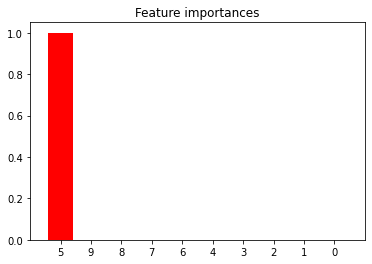

In [0]:
import numpy as np
import matplotlib.pyplot as plt

importances = clf.feature_importances_

plt.figure()
plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_test.shape[1]), indices)
plt.xlim([-1, X_test.shape[1]])
plt.show()

### 5.3.4. Bias vs. Variance in Boosting

* ***boosting*** is averaging many trees (making it more stable)

* making small adjustments to the trees is used to reduce bias by developing a more detailed analysis


* but sometimes ***s*** is too large and we overfit

5.3.5. Computational speed

* can take many cpu cycles

* often good to try multicore in boosting

### 5.3.6. Hyperparamters

* increasing `n_estimators` or decreasing `min_samples_leaf` in boosting will generally reduce bias but increase variance



### 5.3.7. The Learning Rate

* controlls overfitting via *shrinkage*

* we will also use this in SVM and NN soon :)

#### 5.3.7.1. General Concepts

![alt text](https://employees.csbsju.edu/cschaller/Principles%20Chem/conformation/globalmin.gif)


* the algorothim starts with a random guess and iteritively moves toward the minimum of the function

* moves in the direction of the negative gradient until it converges at ~0 grad (change from one step to the next or 0 slope


* **lr** tells us *how much* to increment in the direction of the downward slope in each iteration

* unfortunately it will lead us to local minimum instead if we dont start at near the global by accident

* also smaller lr are preferrable so we dont *miss* the minimum (eg. move all the way accross to the other direction of gradient



##### The learning rate in gradient boosting

* in this case the LR is multiplied by each of the residuals that form the new tree values

* a smaller learning rate may require more trees but reduce overfitting

## 5.4. Pitfall: NO free lunch

* Adaboost is s good 'off-the-shelf' algorithm but there is still always the possibility of over-fitting (with any ml algorithm)

* eg. even if we choose a very high value of ***s***, we could over-fit the individual trees


* good tuning tips for the homework: https://medium.com/@taplapinger/tuning-a-random-forest-classifier-1b252d1dde92